In [3]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, BatchNormalization
from keras.models import Model, load_model 
from keras.utils import get_custom_objects
import keras.backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from IPython.display import display
import pandas as pd
import numpy as np
import os
from random import shuffle, randint, sample
from IPython.display import display
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from adjustText import adjust_text
from glob import glob


Using TensorFlow backend.


# load data

In [4]:
path=os.path.join('.','dataset','gossiping.pickle')
data=pd.read_pickle(path)
data.head(1)

,push_id,is_push,push_author,push_dt,train_or_test,content,label,article_id,push_num,title,href,article_author,article_dt
0,4,推,ebod221,2019-07-01 16:35:00.000000,train,北七,1,1561970056,42,[新聞] 臉書見「國中生外流」爽喊+1 人夫手機遭,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,peterlin495,2019-07-01


In [5]:
# remove '→'
data2=data[data.is_push!='→']
data2.head(1)

,push_id,is_push,push_author,push_dt,train_or_test,content,label,article_id,push_num,title,href,article_author,article_dt
0,4,推,ebod221,2019-07-01 16:35:00.000000,train,北七,1,1561970056,42,[新聞] 臉書見「國中生外流」爽喊+1 人夫手機遭,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,peterlin495,2019-07-01


In [6]:
data2.shape

(590211, 13)

In [7]:
# users 
users=data2.drop_duplicates(subset='push_author')
columns=['push_author']
users=users[columns].reset_index(drop=True)
users['user_id']=users.index
users.tail()


,push_author,user_id
53038,teddy98,53038
53039,icoann,53039
53040,bearweb,53040
53041,littlehouse,53041
53042,icespeech,53042


In [8]:

# movies
movies=data2.drop_duplicates(subset='article_id')
columns=['article_id','href','title','article_author']
movies=movies[columns].reset_index(drop=True)
movies['movie_id']=movies.index
movies.tail()

,article_id,href,title,article_author,movie_id
11438,1449765745,www.ptt.cc/bbs/Gossiping/M.1449765745.A.008.html,[ＦＢ] 林鳳營也有毒？（Rinoal Kuo臉書）,a5378623,11438
11439,1435592523,www.ptt.cc/bbs/Gossiping/M.1435592523.A.3BF.html,[ＦＢ] 神魔之塔臉書,yuzukineko,11439
11440,1445086702,www.ptt.cc/bbs/Gossiping/M.1445086702.A.521.html,[ＦＢ] 某航前陣子在飛機上生小孩 空服員臉書,lacos0212,11440
11441,1397318347,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,Re: [爆卦] 689射惹! 方仰寧的臉書超過19萬粉絲啦!!,andy90498,11441
11442,1410052986,www.ptt.cc/bbs/Gossiping/M.1410052986.A.FCF.html,[新聞] 告網友爆紅女教授 臉書罵同事判賠10萬,wavelet,11442


In [9]:
# 推=>1,噓=>0=>-1
columns=['push_author','article_id','href','label']
data3=data2[columns].copy()
data3['label2']=data3['label'].apply(lambda x: -1 if x == 0 else 1)
data3.head()

,push_author,article_id,href,label,label2
0,ebod221,1561970056,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,1,1
1,yaritai,1561970056,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,1,1
2,obov5116,1561970056,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,0,-1
3,forwardgo,1561970056,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,0,-1
4,kiwi03,1561970056,www.ptt.cc/bbs/Gossiping/M.1561970056.A.18A.html,1,1


In [10]:
# sum all pushs of specific user to specific article
data4=data3.groupby(['article_id', 'push_author','href'])["label2"].sum().reset_index()
data4=data4.rename(columns={'label2':'rating'})
data4.head()

,article_id,push_author,href,rating
0,1397318347,ARASHIRLEY,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1
1,1397318347,CasioMan,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1
2,1397318347,CharleneTsai,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,2
3,1397318347,Cold5566,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-3
4,1397318347,DALUGI,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,1


In [11]:
# clip 
# np.clip(3,5,9)

data5=data4.copy()
data5['rating_clip']=data5['rating'].apply(lambda x: np.clip(x,-5,5))
print(data5.rating.min(),data5.rating.max())
print(data5.rating_clip.min(),data5.rating_clip.max())
data5.head(5)

-143 156
-5 5


,article_id,push_author,href,rating,rating_clip
0,1397318347,ARASHIRLEY,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1,-1
1,1397318347,CasioMan,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1,-1
2,1397318347,CharleneTsai,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,2,2
3,1397318347,Cold5566,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-3,-3
4,1397318347,DALUGI,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,1,1


In [12]:
data6=pd.merge(left=data5, right=users, how='inner', on='push_author')
data6=pd.merge(left=data6, right=movies, how='inner', on=['article_id','href'])
data6.head(2)

,article_id,push_author,href,rating,rating_clip,user_id,title,article_author,movie_id
0,1397318347,ARASHIRLEY,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1,-1,52656,Re: [爆卦] 689射惹! 方仰寧的臉書超過19萬粉絲啦!!,andy90498,11441
1,1397318347,CasioMan,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1,-1,52651,Re: [爆卦] 689射惹! 方仰寧的臉書超過19萬粉絲啦!!,andy90498,11441


In [13]:
data6.shape

(521286, 9)

In [14]:
data_train, data_test, _, _ = train_test_split(data6, data6, test_size=0.1, random_state=42)
data_train.shape,data_test.shape

((469157, 9), (52129, 9))

In [15]:
x_train=[data_train.user_id.values,
         data_train.movie_id.values]
y_train=[data_train.rating_clip.values]

x_valid=[data_test.user_id.values,
         data_test.movie_id.values]
y_valid=[data_test.rating_clip.values]


# model

In [16]:
def rmse(y_true, y_pred, bound=2):
    max_rating=bound*2
    y_pred = K.clip(y_pred, 0.0, max_rating)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))

get_custom_objects().update({"rmse": rmse})


In [17]:
len(movies),len(users)

(11443, 53043)

In [18]:
input_length=1
n_movies=len(movies)
n_users=len(users)
latent_dim=40

user_input = Input(shape=(input_length,))
movie_input = Input(shape=(input_length,))

user_vecter = Embedding(input_dim=n_users, output_dim=latent_dim, input_length=input_length, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)

movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)


rating_predict = dot([user_vecter,movie_vecter],axes=1)

model = Model([user_input,movie_input],rating_predict)

model.compile(loss="mse", optimizer="adam", metrics=[rmse])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 40)        2121720     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 40)        457720      input_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 

In [19]:

# path=os.path.join('.','dataset','weights','test')

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    
# make_dir(path)

In [20]:
early_stopping = EarlyStopping(monitor='val_rmse', mode='min', verbose=1, patience=10, min_delta=0.001)
    
dir_name='ptt_fb-laten_40'
dir_path=os.path.join('.','dataset','weights',dir_name)
make_dir(dir_path)

file_name = 'recommender'
file_name += '-'+"epoch_{epoch:02d}-val_rmse_{val_rmse:.3f}.hdf5"
path=os.path.join(dir_path,file_name)
checkpointer = ModelCheckpoint(filepath=path, verbose=1, monitor='val_rmse', save_best_only=True, mode='min', period=1)


In [21]:
# https://www.youtube.com/watch?v=BZh1ltr5Rkg
# https://stackoverflow.com/questions/47312219/what-does-non-trainable-params-mean

epochs=100
batch_size=1000
history = model.fit(x_train,y_train,
                    validation_data=(x_valid,y_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1, 
                    shuffle=True,
                    callbacks=[early_stopping,checkpointer]
                    )

Train on 469157 samples, validate on 52129 samples
Epoch 1/100
469157/469157 [==============================] - 5s 10us/step - loss: 1.3953 - rmse: 1.1782 - val_loss: 1.3930 - val_rmse: 1.1789

Epoch 00001: val_rmse improved from inf to 1.17895, saving model to ./dataset/weights/ptt_fb-laten_40/recommender-epoch_01-val_rmse_1.179.hdf5
Epoch 2/100
469157/469157 [==============================] - 2s 4us/step - loss: 1.1502 - rmse: 1.0872 - val_loss: 0.9497 - val_rmse: 1.0065

Epoch 00002: val_rmse improved from 1.17895 to 1.00648, saving model to ./dataset/weights/ptt_fb-laten_40/recommender-epoch_02-val_rmse_1.006.hdf5
Epoch 3/100
469157/469157 [==============================] - 2s 4us/step - loss: 0.7070 - rmse: 0.9088 - val_loss: 0.7301 - val_rmse: 0.9149

Epoch 00003: val_rmse improved from 1.00648 to 0.91493, saving model to ./dataset/weights/ptt_fb-laten_40/recommender-epoch_03-val_rmse_0.915.hdf5
Epoch 4/100
469157/469157 [==============================] - 2s 5us/step - loss: 0.51

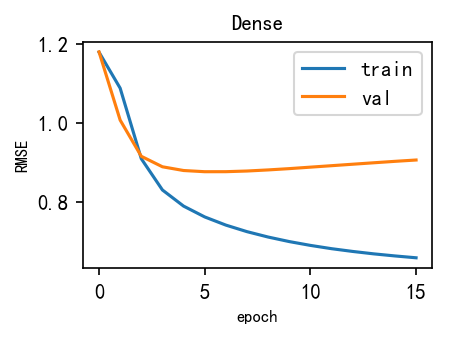

In [22]:
def plot_history(history):
    plt.figure(figsize=(3,2), dpi=150)
    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('Dense', fontsize=10)
    plt.ylabel('RMSE', fontsize=8)
    plt.xlabel('epoch', fontsize=8)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history)

# load best model

In [23]:
dir_path

'./dataset/weights/ptt_fb-laten_40'

In [24]:
weights=glob(os.path.join(dir_path,'*')) 
weights.sort()
best_weight=weights[-1]
print(best_weight)
best_nn=load_model(best_weight)
best_nn.summary()

./dataset/weights/ptt_fb-laten_40/recommender-epoch_07-val_rmse_0.876.hdf5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 40)        2121720     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 40)        457720      input_6[0][0]                    
__________________________________

In [25]:
best_nn.layers

In [26]:
input_ = best_nn.layers[0].input
x = best_nn.layers[2](input_)
output_ = best_nn.layers[4](x)
model_user_embedding = Model(input_, output_)
model_user_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1, 40)             2121720   
_________________________________________________________________
flatten_5 (Flatten)          (None, 40)                0         
Total params: 2,121,720
Trainable params: 2,121,720
Non-trainable params: 0
_________________________________________________________________


In [27]:
user_vectors=model_user_embedding.predict([n_users-1,n_users-0])
print(user_vectors.shape)
user_vectors

(2, 40)


array([[-0.11764683,  0.07099026,  0.03421322,  0.10864174, -0.01805126,
        -0.08815576, -0.06308708, -0.01340638, -0.02952881, -0.03715156,
        -0.08744463, -0.00991864,  0.09969554, -0.14219488,  0.03704872,
        -0.08412788, -0.00426883,  0.12845258, -0.0925171 , -0.10812353,
        -0.05976238, -0.06602857, -0.03310791, -0.00776649,  0.01823803,
         0.1525456 ,  0.09903277,  0.0738506 ,  0.07853425,  0.06770176,
         0.04760423, -0.03320961,  0.09994453, -0.08750535,  0.00185318,
        -0.07906269,  0.03967951, -0.0816996 , -0.0870363 ,  0.0771283 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.

In [28]:
user_vectors=model_user_embedding.predict(users.user_id.values)
print(user_vectors.shape)

(53043, 40)


# tsne

In [29]:
data6.head(1)

,article_id,push_author,href,rating,rating_clip,user_id,title,article_author,movie_id
0,1397318347,ARASHIRLEY,www.ptt.cc/bbs/Gossiping/M.1397318347.A.88B.html,-1,-1,52656,Re: [爆卦] 689射惹! 方仰寧的臉書超過19萬粉絲啦!!,andy90498,11441


In [ ]:
# suspicious_id=['shamanlin',]

# one

In [101]:
clue1=data6[data6.push_author=='shamanlin'].sort_values(by='rating')
clue1

,article_id,push_author,href,rating,rating_clip,user_id,title,article_author,movie_id
448159,1559642302,shamanlin,www.ptt.cc/bbs/Gossiping/M.1559642302.A.C07.html,-1,-1,6105,[新聞] 網球》謝淑薇臉書發文 願出戰2020奧運,HiranoMiu,1976
458460,1561467043,shamanlin,www.ptt.cc/bbs/Gossiping/M.1561467043.A.578.html,-1,-1,6105,[臉書] 苗博雅,g21l,374
502318,1544101039,shamanlin,www.ptt.cc/bbs/Gossiping/M.1544101039.A.FC6.html,-1,-1,6105,Re: [新聞] 外館臉書改「Taiwan」國民黨批：傷害、羞,azero,10556
518262,1546571440,shamanlin,www.ptt.cc/bbs/Gossiping/M.1546571440.A.3CC.html,-1,-1,6105,Re: [爆卦] 臉書用戶IP來自台灣、中國的語言分佈,odd5566,9550
466475,1554272480,shamanlin,www.ptt.cc/bbs/Gossiping/M.1554272480.A.295.html,1,1,6105,Re: [臉書] 三年前林奕含於婚禮演講：他要做一個,solumate,5578
492943,1547298295,shamanlin,www.ptt.cc/bbs/Gossiping/M.1547298295.A.73D.html,1,1,6105,[新聞] 《來去高雄》MV惹議 白冰冰臉書PO文為,huart,9146


In [99]:
clue1.shape,clue1.user_id.unique().shape,clue1.movie_id.unique().shape,

((2, 9), (1,), (2,))

In [96]:
# c1=data6.title.str.contains('柯文哲')
c2=data6.movie_id.isin(clue1.movie_id.values)
data_select=data6[c2]
data_select.shape

(17983, 9)

In [97]:
data_select.shape,data_select.user_id.unique().shape,data_select.movie_id.unique().shape,

((17983, 9), (8545,), (180,))

In [86]:
select_id=data_select.user_id.unique()

select_user_vectors=user_vectors[select_id,...]
select_user_vectors.shape

(172, 40)

In [87]:
# n=2000
# select_user_vectors=select_user_vectors[:n]
# select_user_vectors.shape

In [88]:
model_tsne = TSNE(n_components=2, random_state=0, perplexity=5)
select_user_vectors_tsne = model_tsne.fit_transform(select_user_vectors)
select_user_vectors_tsne.shape

(172, 2)

# visualize

In [89]:
# word = select_id
word = data_select.push_author.unique()

x = select_user_vectors_tsne[:,0]
y = select_user_vectors_tsne[:,1]

# n=1000
# x=x[:n]
# y=y[:n]
# word=word[:n]

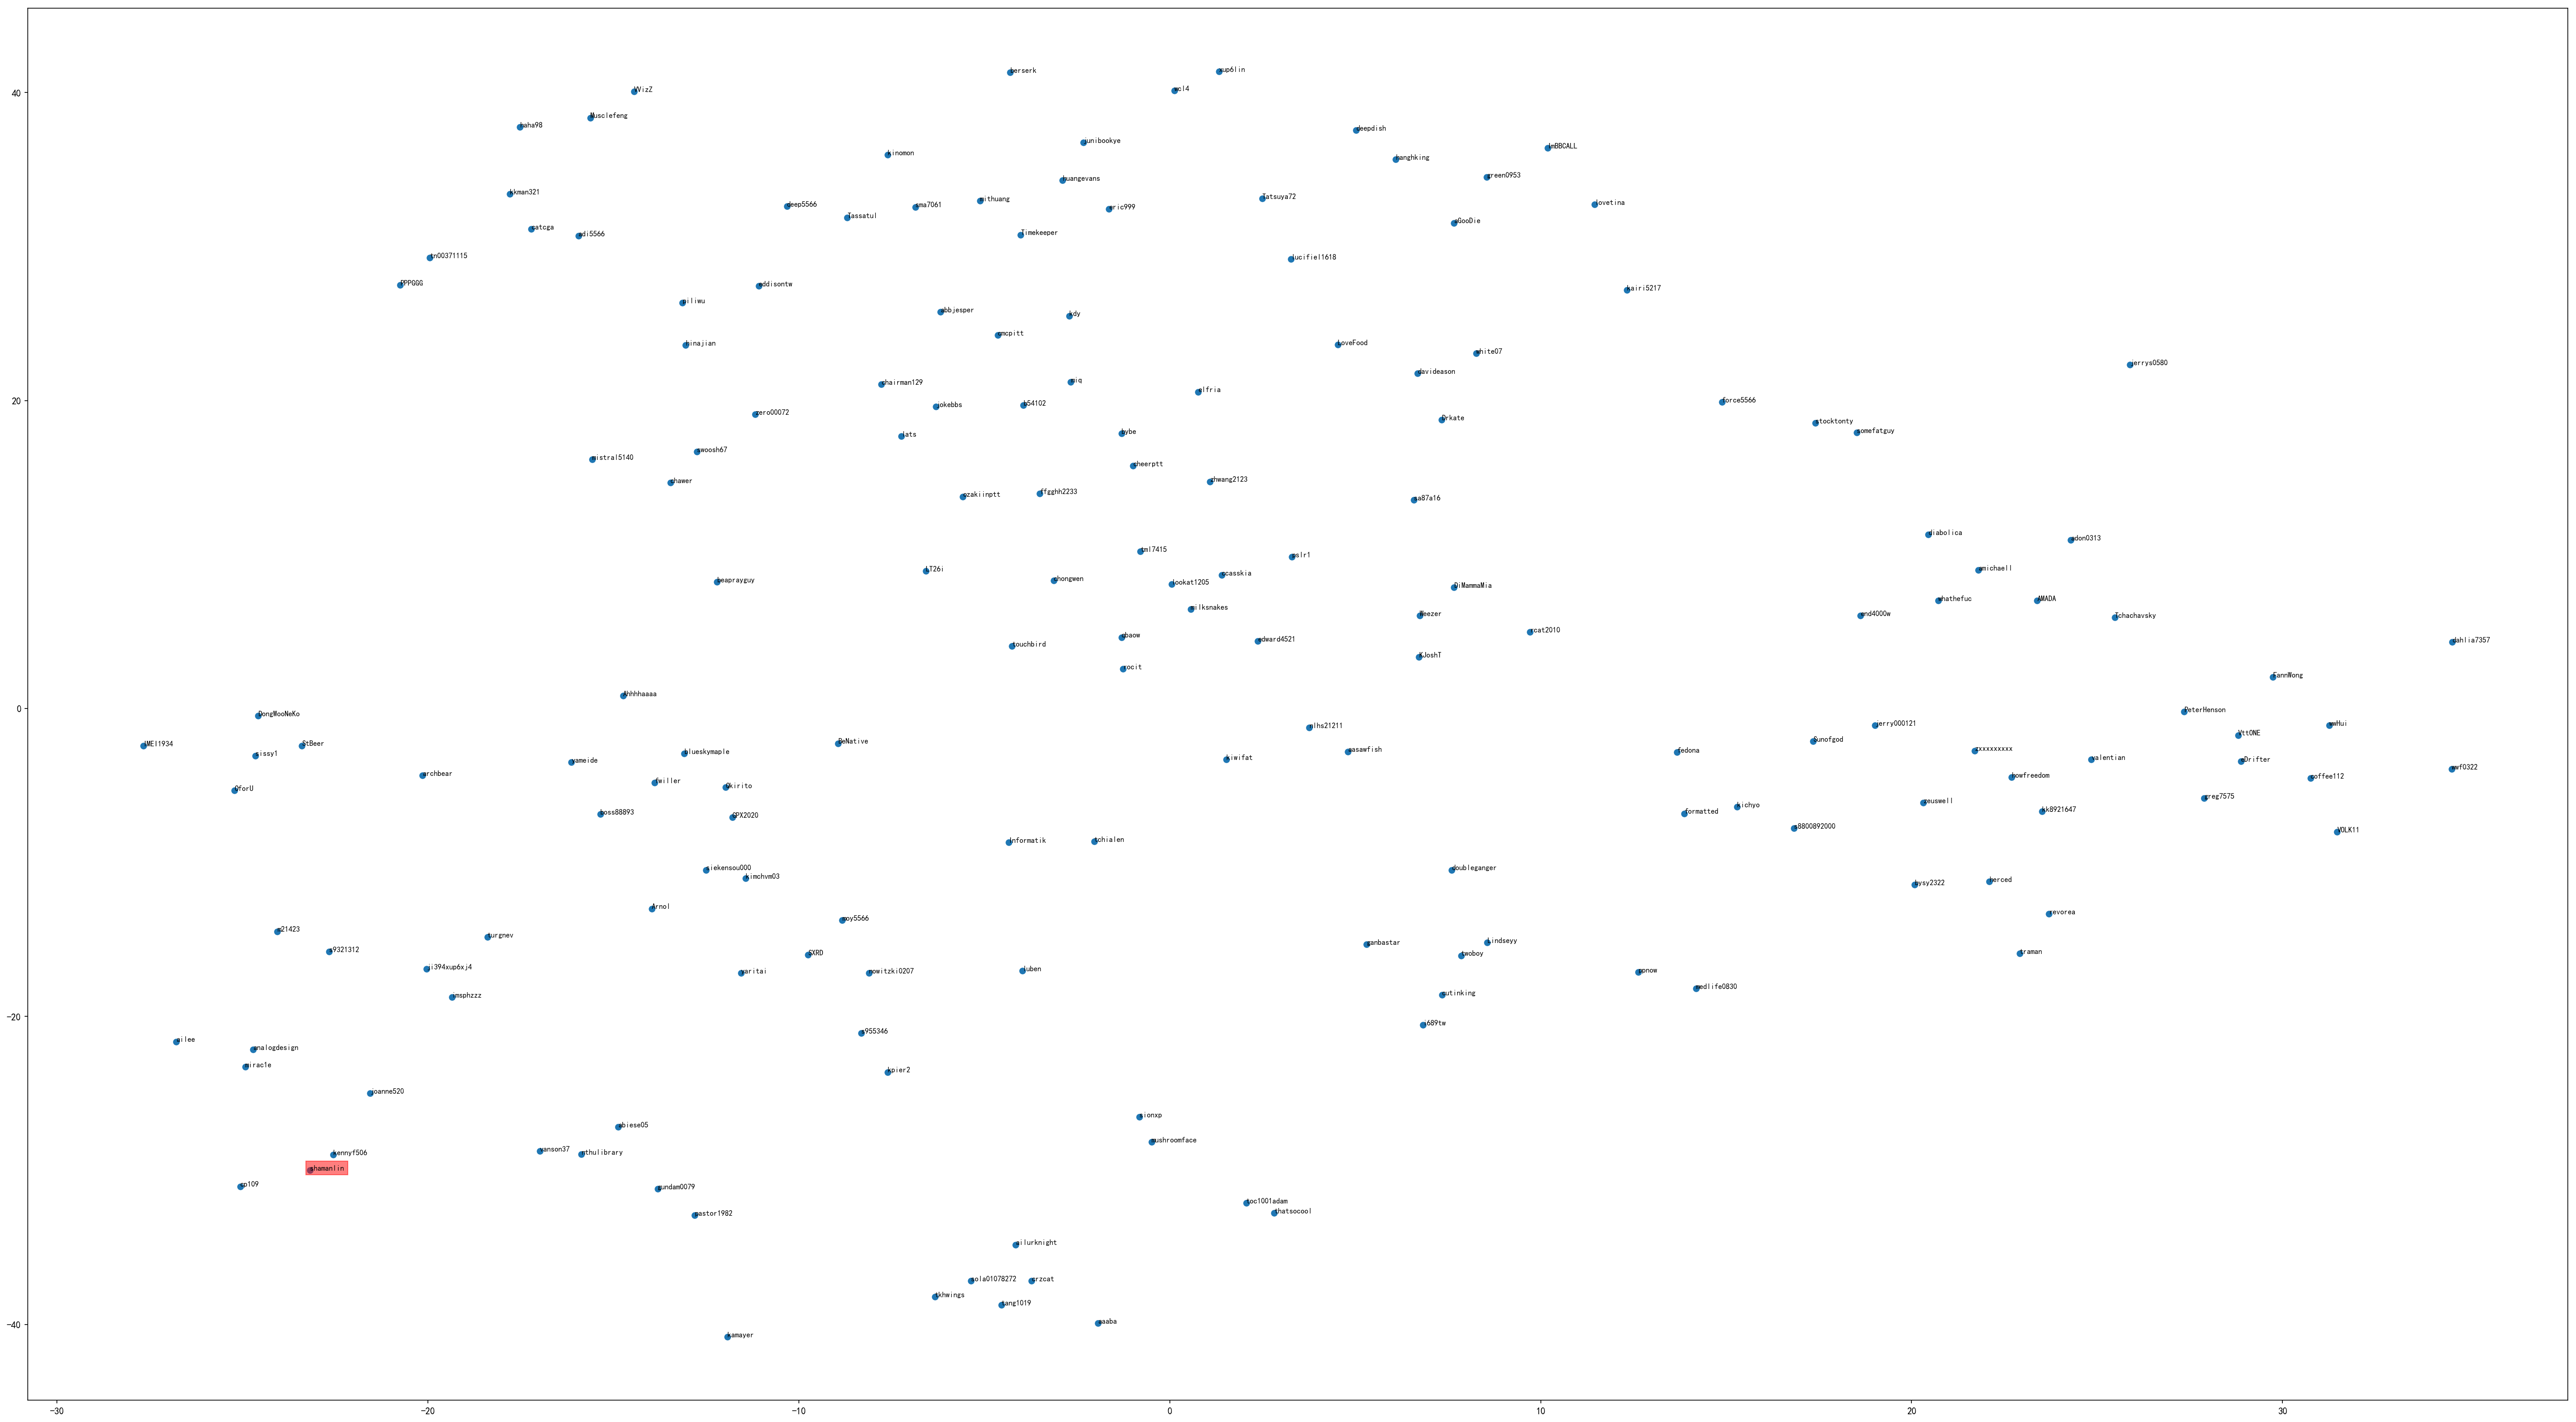

In [90]:
x_y_word = []
plt.figure(figsize=(16*3,9*3),dpi=150)
plt.rcParams['axes.unicode_minus'] = False 

plt.scatter(x,y)

for a, b, s in zip(x, y, word):
    
    if s=='shamanlin':
        x_y_word.append(plt.text(a, b, s,fontsize=8, 
                                 bbox=dict(color='red', alpha=0.5)))
    else:
        x_y_word.append(plt.text(a, b, s, 
                                 fontsize=8))
    
# adjust_text(x_y_word, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

plt.show()

In [91]:
1/0

ZeroDivisionError: division by zero